In [1]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler




import xlrd
import pandas as pd

book = xlrd.open_workbook('dataset for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data_unreplicated = [[sheet.cell_value(r, c)
         for c in range(1,9)] for r in range(2,74)]
scaler = StandardScaler()
scaler.fit(data_unreplicated)


book = xlrd.open_workbook('prepareddatakfold.xlsx')
sheet = book.sheet_by_name('Sheet1')
replicated_data = [[sheet.cell_value(r, c)
         for c in range(0,8)] for r in range(0,7200)]

def create_inout_sequences(input_data, tw):
    training_seq = []
    label_seq = []
    L = len(input_data)
    for i in range(0,L,tw):
        train_seq = input_data[i:i+tw,0:5]
        train_label = input_data[i:i+tw,5:8]
        training_seq.append(train_seq)
        label_seq.append(train_label)
    return training_seq,label_seq

standardised_data = scaler.transform(replicated_data)
x = torch.tensor(standardised_data)
z, t = create_inout_sequences(x, 12)
training_seq = torch.stack(z)
label_seq = torch.stack(t)
batch_size = 8
train = torch.utils.data.TensorDataset(training_seq,label_seq)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size, 
                                           shuffle=False)






In [2]:
import torch.nn as nn
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [3]:
import torch
input_dim = 5
hidden_dim = 15
layer_dim = 1
output_dim = 3

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
loss_fn = torch.nn.MSELoss(reduction='mean')

In [143]:
from tqdm import tqdm
from torch.autograd import Variable
model.train()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 50

for epoch in range (epochs+1):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 12, 5))  
        b_y = Variable(y.view(-1, 12, 3))
    # Forward pass
        optimizer.zero_grad()
        y_pred = model(b_x.float())
    # Compute and print loss.
        loss = loss_fn(y_pred, b_y.float())
       
        loss.backward()
        optimizer.step()
        
    print(epoch, loss.item())



print(b_y)    
print(y_pred)


0 0.5652318596839905
1 0.5220507383346558
2 0.4826056957244873
3 0.41996368765830994
4 0.376041054725647
5 0.3321297764778137
6 0.29881182312965393
7 0.2682330310344696
8 0.2596360743045807
9 0.24990954995155334
10 0.2420690655708313
11 0.23665188252925873
12 0.23340539634227753
13 0.2309664785861969
14 0.2285921573638916
15 0.2260107696056366
16 0.22292274236679077
17 0.2191978096961975
18 0.21478775143623352
19 0.20983335375785828
20 0.2048766314983368
21 0.20083050429821014
22 0.19736550748348236
23 0.1960575431585312
24 0.19702258706092834
25 0.20232795178890228
26 0.2076815664768219
27 0.2068687081336975
28 0.20206540822982788
29 0.19679979979991913
30 0.1915636509656906
31 0.18563362956047058
32 0.1781725138425827
33 0.1713608056306839
34 0.1669706404209137
35 0.16552038490772247
36 0.16727060079574585
37 0.16647326946258545
38 0.16151674091815948
39 0.15644840896129608
40 0.15375544130802155
41 0.15193511545658112
42 0.14831292629241943
43 0.14548562467098236
44 0.14594452083110

         [-1.4280e+00, -2.6090e-01, -2.2496e+00]]], grad_fn=<AddBackward0>)


In [144]:
torch.save(model.state_dict(), ("C:/Users/Gabriel/Documents/Python/RNN1.pt"))                
                                

In [4]:
import xlrd
import numpy as np
from sklearn.preprocessing import StandardScaler
model.load_state_dict(torch.load("C:/Users/Gabriel/Documents/Python/RNN1.pt"))
model.eval()
book = xlrd.open_workbook('dataset for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data4 = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(2,74)]
data5 = [[sheet.cell_value(r, c)
         for c in range(6,9)] for r in range(2,74)]
scaler = StandardScaler()
scaler2 = StandardScaler()

In [5]:
book = xlrd.open_workbook('Experimental Data edited.xlsx')
sheet = book.sheet_by_name('Sheet2')

data = [[sheet.cell_value(r, c)
         for c in range(1,6)] for r in range(114,126)]
data2 = [[sheet.cell_value(r, c)
         for c in range(1,4)] for r in range(114,126)]
data3 = [[sheet.cell_value(r, c)
         for c in range(1,4)] for r in range(115,127)]
actual_results = torch.tensor(data3)

scaler.fit(data4)
scaler2.fit(data5)
n = np.array(data)
q= torch.tensor(n[:,:])
standardised_data = scaler.transform(data)

standardised_data2 = standardised_data[:, 0:3] 



x_raw = torch.tensor(standardised_data[:,:])
z = torch.tensor(standardised_data2[0:1,:])
v = torch.tensor(data3)


with torch.no_grad():
        x=x_raw.view(1,12,5)
        dx_dt_pred = model(x.float())
        predictions= np.array(dx_dt_pred)
        descaled_predictions = scaler2.inverse_transform(predictions)
        usable_predictions = torch.tensor(descaled_predictions)
        q[:, 0:3]  = (usable_predictions*12) + q[:, 0:3]
        np_x = np.array(q)
        
     
        
    
predictions_final=torch.tensor(np_x)

x_plot=predictions_final.view(12, 5)


tensor([[2.6670e-01, 7.2290e+02, 4.6200e-01],
        [4.5930e-01, 5.7480e+02, 7.7700e-01],
        [6.3910e-01, 5.1690e+02, 1.2180e+00],
        [8.7080e-01, 4.0420e+02, 1.8060e+00],
        [1.1327e+00, 3.3580e+02, 2.3520e+00],
        [1.3546e+00, 5.3840e+02, 2.7720e+00],
        [1.5643e+00, 8.1020e+02, 3.3180e+00],
        [1.7803e+00, 1.0283e+03, 3.9690e+00],
        [1.9670e+00, 1.2304e+03, 4.3680e+00],
        [2.1856e+00, 1.4846e+03, 4.5360e+00],
        [2.2902e+00, 1.6678e+03, 4.6200e+00],
        [2.3581e+00, 1.8851e+03, 4.5570e+00]])


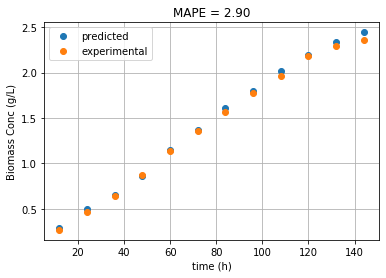

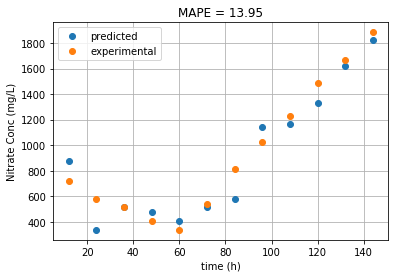

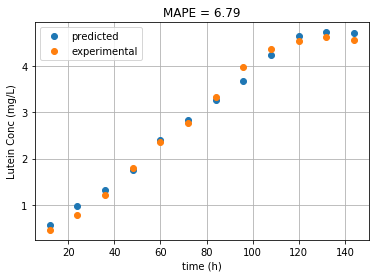

In [7]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-y_pred[i:1+i,:])/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100
    return MAPE_Total

import numpy as np
a = np.linspace(12,144,12)
v = torch.tensor(data3)
print(v)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Lutein Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 



In [8]:
import pandas as pd
b=np.array(v)
c=np.array(x_plot)
book = xlrd.open_workbook('tested data.xlsx')
sheet = book.sheet_by_name('Sheet1')
writer = pd.ExcelWriter('tested data.xlsx', engine='xlsxwriter')
df1 = pd.DataFrame(b)
df1.to_excel(writer, header=True, index=True)
df2 = pd.DataFrame(c)
df2.to_excel(writer, startrow=13, header=True, index=True)
writer.save()